In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import statsmodels.formula.api as smf
from matplotlib.patches import Patch

%matplotlib inline

In [2]:
# Importing the groundwater measurement data in Pickle format
df_ms_ws_input = pd.read_pickle("../data/processed/grundwasserdaten-NRW/GW-MessWasserstellenMerge.pkl")
df_ms_slope_per_year_gis = pd.read_pickle("../data/processed/grundwasserdaten-NRW/GW-MessstellenSlopePerYearGIS.pkl")

# Visualisierung der Grundwasserstände mit Trendlinie

## Grundwasserganglinie einer Referenzmessstelle

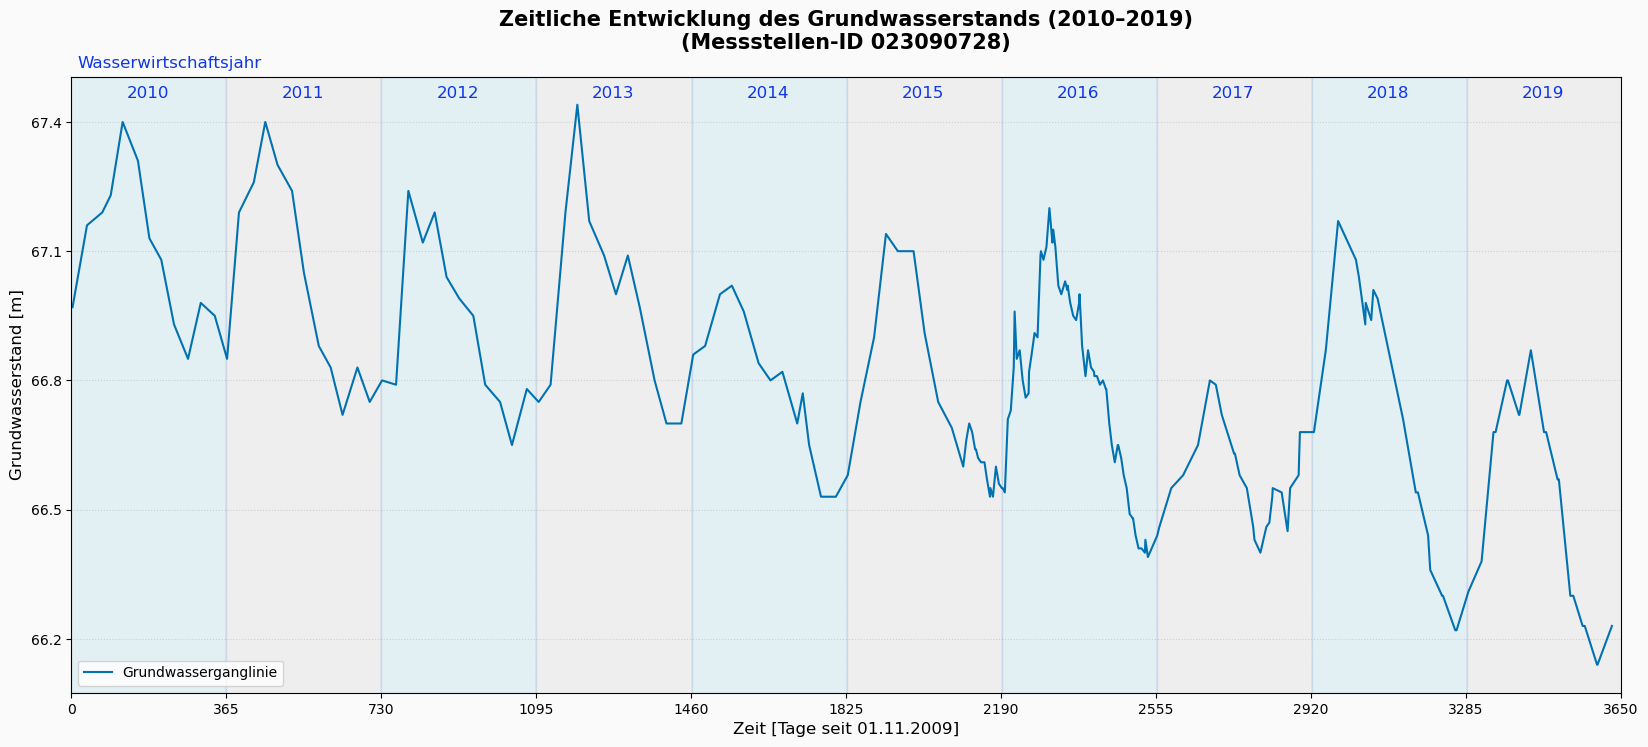

In [3]:
# Startdatum
tage_pro_jahr = 365.25 # Mit Schaltjahr
startjahr = 2010 # Kalendarisches Datum
t0 = pd.Timestamp("2009-11-01") # Beginn des Wasserwirtschaftsjahr 2010

visualized_ms = '023090728'

df_relevant_ms = (
        df_ms_ws_input
        .loc[df_ms_ws_input.loc[:, 'messstelle_id'] == visualized_ms]
        .sort_values('datum_messung')
        .copy()
        )

df_relevant_ms["t"] = (df_relevant_ms["datum_messung"] - t0).dt.days


# Plotten zufällig ausgewählter Grundwasserpegel
fig, ax = plt.subplots(figsize=[20, 8], nrows=1, ncols=1)

# Regressionslinien
df_relevant_ms.plot(kind='line', x='t', y='wasserstd_m', ax=ax, legend=True, color='#0072B2')

ax.legend(["Grundwasserganglinie"])
ax.set_title(f"Zeitliche Entwicklung des Grundwasserstands (2010–2019)\n(Messstellen-ID {visualized_ms})",
             fontsize=15, fontweight="bold", color="black", pad=20)
ax.set_xlabel(f"Zeit [Tage seit {t0.strftime("%d.%m.%Y]")}", fontsize=12)
ax.set_ylabel("Grundwasserstand [m]", fontsize=12)
ax.set_xticks([jahr * 365 for jahr in range(11)])
ax.set_yticks([66.2, 66.5, 66.8, 67.1 , 67.4])
ax.set_yticklabels(['66.2', '66.5', '66.8', '67.1', '67.4'], rotation=0)
ax.set_xlim(0, 3651)
ax.grid(True, linestyle=':', alpha=0.5, axis='y')

ax.text(x=15, y=67.525, s='Wasserwirtschaftsjahr', fontsize=12, color="#002AE6F0")

# farbige Hintergrundflächen
for jahr in range(10):
    start = jahr * tage_pro_jahr
    ende = (jahr + 1) * tage_pro_jahr

    ax.axvspan(start, ende, color=("lightblue" if jahr % 2 == 0 else "lightgray"), 
               alpha=0.3, label='_nolegend_')

# Darstellung der Wasserwirtschaftsjahre
for jahr in range(10):   # 10 Jahre = 11 Marken
    x_pos = jahr * tage_pro_jahr + 180
    y_pos = 67.45
   
    ax.text(
        x = x_pos,                          # x-Position
        y = y_pos,                          # y-Position (oben)
        s = str(startjahr + jahr),          # Text
        ha="center", va="bottom",           # horizontale/vertikale Ausrichtung
        fontsize=12, color="#002AE6F0"
    )

# Darstellung der Wasserwirtschaftsjahre
for jahr in range(11):   # 10 Jahre = 11 Marken
    x_pos = jahr * tage_pro_jahr
    ax.axvline(x=x_pos, color="blue", linestyle=":", alpha=0.7, linewidth=0.2, label='_nolegend_')

# Hintergrundfarben
ax.set_facecolor('#FAFAFA')
fig.patch.set_facecolor('#FAFAFA')

In [4]:
fig.savefig("../pictures/04_visual_slope_per_year_2010-2019_1.png", dpi=300, bbox_inches="tight")

## Grundwasserganglinie einer Referenzmessstelle mit Trendlinie

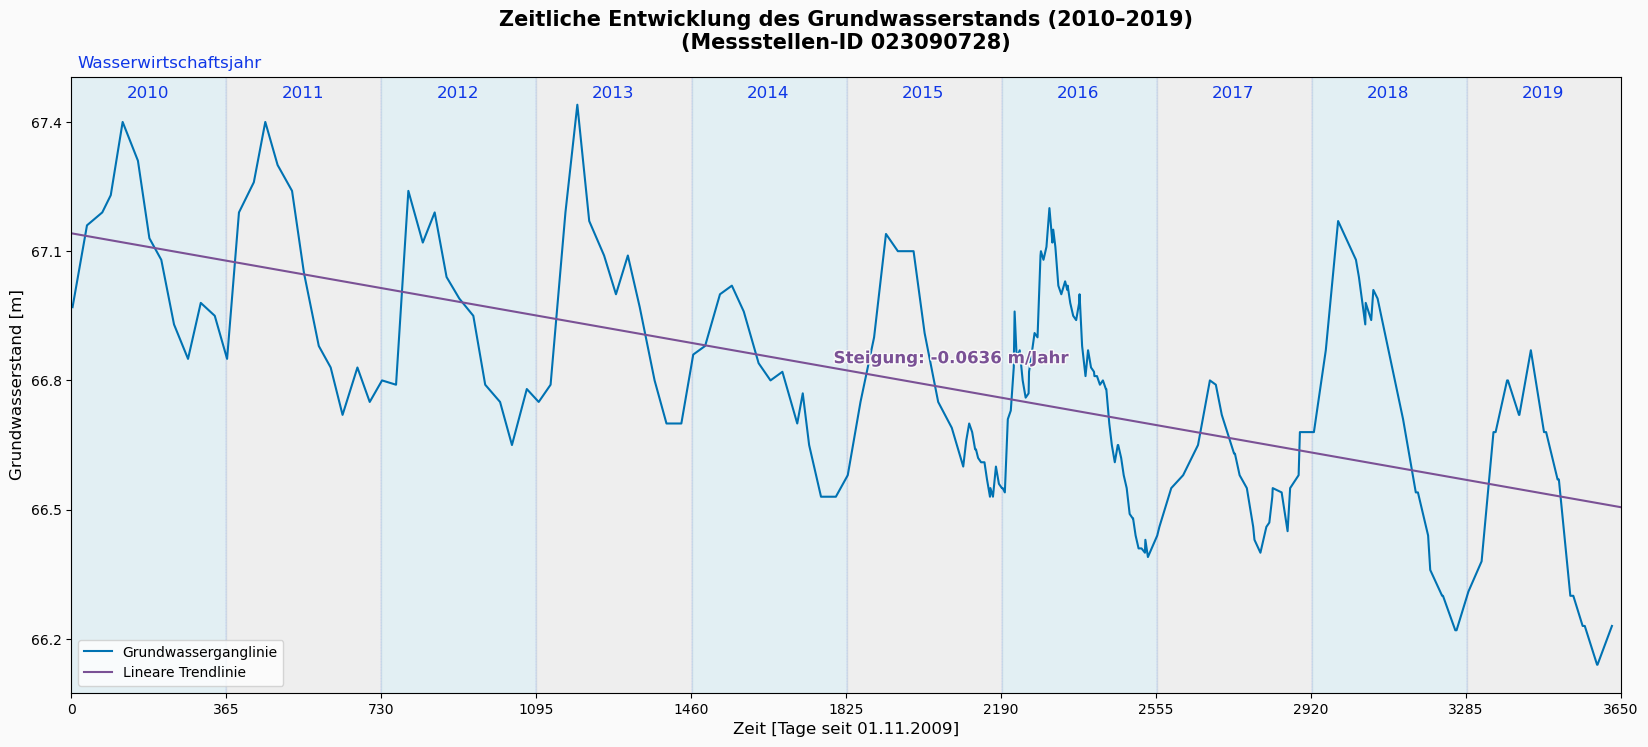

In [5]:
# Lineare Regression
model_relevant_ms = smf.ols(formula='wasserstd_m ~ t', data=df_relevant_ms)
results_relevant_ms = model_relevant_ms.fit()

# Add trendline und label
(results_relevant_ms.predict(pd.DataFrame({"t": range(3651)}))).plot(ax=ax, color='#7A5195', legend=True)

ax.text(x=sum(ax.get_xlim()) / 2 - 30, y=sum(ax.get_ylim()) / 2 + 0.05,
           s=f"Steigung: {results_relevant_ms.params["t"] * 365.25:.4f} m/Jahr",
           path_effects=[path_effects.Stroke(linewidth=2, foreground='#FAFAFA'), path_effects.Normal()],
           fontsize=12, fontweight="bold", color='#7A5195')

ax.legend(["Grundwasserganglinie", "Lineare Trendlinie"])

fig

In [6]:
fig.savefig("../pictures/04_visual_slope_per_year_2010-2019_2.png", dpi=300, bbox_inches="tight")

## Häufigkeitsverteilung der Trendklassen der jährlichen Grundwasseränderung

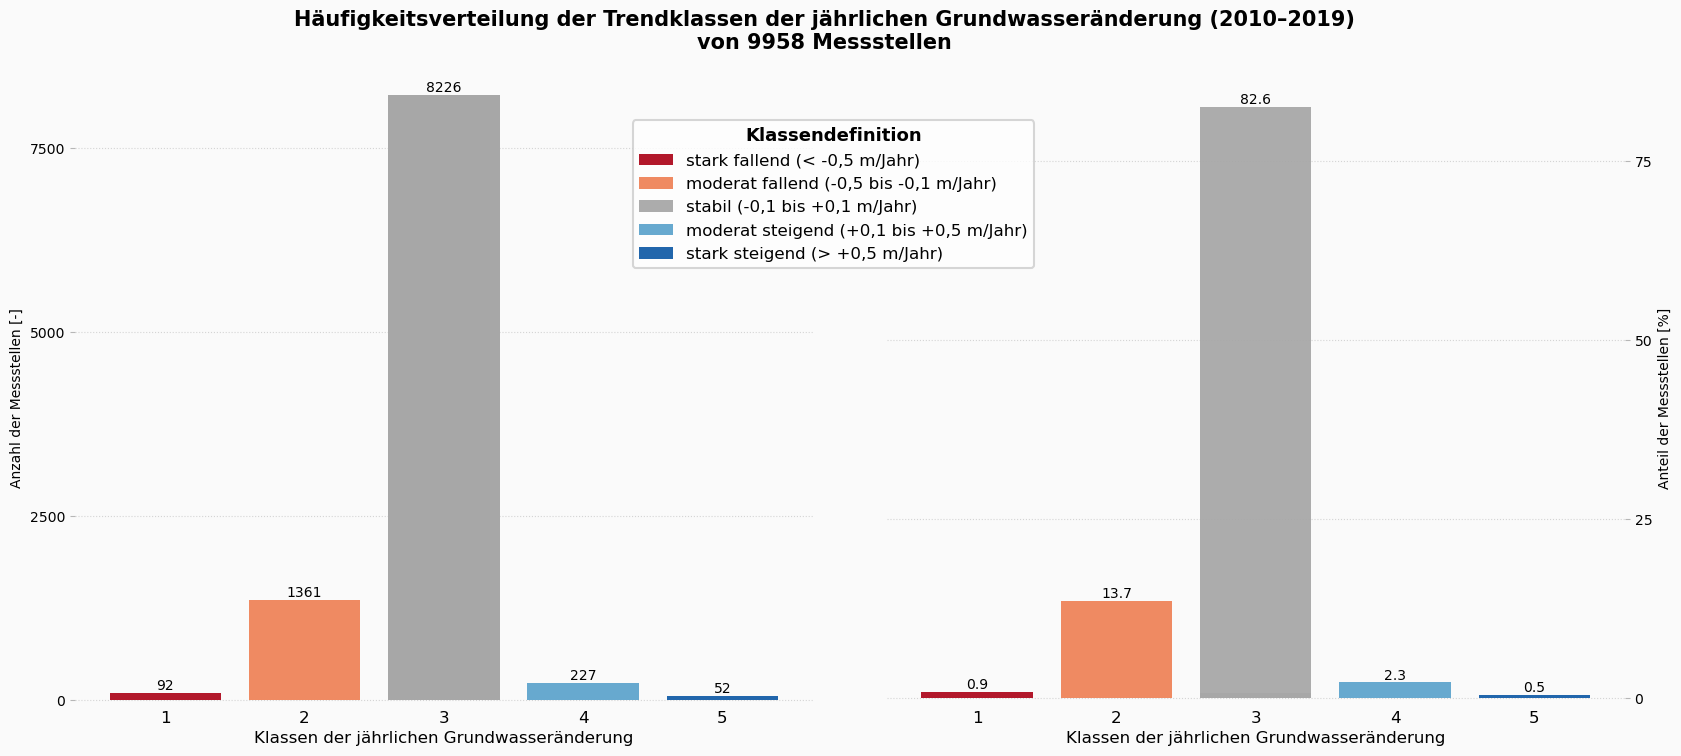

In [7]:
farbklassen = {
    1: {"farbe": "#b2182b", "label": "stark fallend (< -0,5 m/Jahr)"},
    2: {"farbe": "#ef8a62", "label": "moderat fallend (-0,5 bis -0,1 m/Jahr)"},
    3: {"farbe": "#a7a7a7ef", "label": "stabil (-0,1 bis +0,1 m/Jahr)"},
    4: {"farbe": "#67a9cf", "label": "moderat steigend (+0,1 bis +0,5 m/Jahr)"},
    5: {"farbe": "#2166ac", "label": "stark steigend (> +0,5 m/Jahr)"}
}

abs_counts = (
    df_ms_slope_per_year_gis.loc[:, "slope_m_yr_class"]
    .astype("Int64")
    .value_counts()
    .reindex(farbklassen.keys(), fill_value=0)
)

rel_counts = (
    df_ms_slope_per_year_gis.loc[:, "slope_m_yr_class"]
    .astype("Int64")
    .value_counts(normalize=True)
    .reindex(farbklassen.keys(), fill_value=0)
)

farben_liste = [farbklassen[k]["farbe"] for k in abs_counts.index]

# Plotten zu visualisierenden Grundwasserpegel
fig, ax = plt.subplots(figsize=[20, 8], nrows=1, ncols=2)

(
    df_ms_slope_per_year_gis.loc[:,'slope_m_yr_class']
    .value_counts(normalize=False)
    .sort_index()
    .plot(kind='bar', ax=ax[0], color=farben_liste, width=0.8)
)

(
    df_ms_slope_per_year_gis.loc[:,'slope_m_yr_class']
    .value_counts(normalize=True)
    .sort_index().mul(100)
    .plot(kind='bar', ax=ax[1], color=farben_liste, width=0.8)
)

# Beschriftung der einzelnen Balken
for bar in ax[0].bar(range(len(abs_counts)), abs_counts, color=farben_liste):
    h = bar.get_height() 
    ax[0].text(
        bar.get_x() + bar.get_width() / 2,
        h,
        f"{int(h)}",
        ha="center",
        va="bottom"
    )
for bar in ax[1].bar(range(len(rel_counts)), rel_counts, color=farben_liste):
    h = bar.get_height()
    ax[1].text(
        bar.get_x() + bar.get_width() / 2,
        h * 100,
        f"{(h * 100):.1f}",
        ha="center",
        va="bottom"
    )

ax[1].yaxis.set_ticks_position('right')
ax[1].yaxis.tick_right()
ax[1].tick_params(axis="y", labelleft=False, labelright=True)
ax[1].yaxis.set_label_position("right")

for axes in range(2):
    ax[axes].grid(True, linestyle=':', alpha=0.5, axis='y')
    ax[axes].set_axisbelow(True)
    ax[axes].set_xlabel('Klassen der jährlichen Grundwasseränderung', fontsize=12)
    ax[axes].set_xticklabels(['1', '2', '3', '4', '5'], rotation=0, fontsize= 12)
    ax[axes].tick_params(axis='y', colors="#B6B6B6", labelcolor='black')

    if axes == 0:
        ax[axes].set(ylim=[-80, 8300])
        ax[axes].set_yticks([0, 2500, 5000, 7500])
        ax[axes].set_yticklabels(['0', '2500', '5000', '7500'], rotation=0)
        ax[axes].set_ylabel('Anzahl der Messstellen [-]', fontsize=10)
    if axes == 1:
        ax[axes].set(ylim=[-1, 85])
        ax[axes].set_yticks([0, 25, 50, 75])
        ax[axes].set_yticklabels(['0', '25', '50', '75'], rotation=0)
        ax[axes].set_ylabel('Anteil der Messstellen [%]', fontsize=10)
    
    ax[axes].set_facecolor('#FAFAFA')

    for spine in ax[axes].spines.values(): # Ausblenden der Umrahmung der Achsen
        spine.set_visible(False)
    ax[axes].tick_params(axis="x", which="both", length=0)

# Legende
ax[1].set_zorder(ax[0].get_zorder() - 1)

handles = [
    Patch(
        facecolor=patch.get_facecolor(),
        label=farbklassen[i]['label']
    )
    for i, patch in zip(abs_counts.index, ax[axes].patches)
    ]

leg = ax[0].legend(
    frameon=True,
    handles=handles,
    title="Klassendefinition",
    loc="upper right",
    fontsize=12,
    bbox_to_anchor=(1.3, 0.95),
    borderaxespad=0
)

leg.get_frame().set_linewidth(1.5)
leg.get_title().set_fontsize(13)
leg.get_title().set_fontweight("bold")
leg.set_zorder(100)

# Hintergrundfarben
fig.tight_layout
fig.subplots_adjust(wspace=0.1)
fig.suptitle(
    f'Häufigkeitsverteilung der Trendklassen der jährlichen Grundwasseränderung (2010–2019)\n'
    f'von {abs_counts.sum()} Messstellen', fontsize=15, fontweight="bold")
fig.patch.set_facecolor('#FAFAFA')


In [8]:
fig.savefig("../pictures/04_visual_slope_per_year_2010-2019_3.png", dpi=300, bbox_inches="tight")